<a href="https://colab.research.google.com/github/berasaikat/aml-assignment-1/blob/main/src/colab_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import numpy, random
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, utils

In [2]:
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
from tqdm import tqdm
import os

from google.colab import drive

In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
! ln -s /content/drive/MyDrive/aml-assignments/assignment-1/ assignment-1
DIR = "assignment-1/data/fashion-mnist/"
df = pd.read_csv(DIR + "fashion-mnist_train.csv")
df_test = pd.read_csv(DIR + "fashion-mnist_test.csv")

In [57]:
pixel_columns = [f"pixel{i}" for i in range(1, 785)]
pixel_values = df[pixel_columns].values

# Flatten the pixel values into a single sequence
pixel_values = pixel_values.flatten()

# Calculate the mean and std across all pixel values
mean = numpy.mean(pixel_values)
std = numpy.std(pixel_values)

# Print the calculated mean and std
print("Mean for the entire dataset:", mean)
print("Standard Deviation for the entire dataset:", std)

Mean for the entire dataset: 72.9568306122449
Standard Deviation for the entire dataset: 89.96686298512094


In [7]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df.loc[idx, "label"]
        image_pixels = (
            self.df.loc[idx, "pixel1":].values.astype(float).reshape(28, 28, 1)
        )  # Assuming it's a 28x28 image

        if self.transform:
            image_pixels = self.transform(image_pixels)

        return image_pixels, label

In [58]:
normalize_transform = transforms.Normalize(mean=mean, std=std)

# Add the normalization transformation to the existing transformations
train_transform = transforms.Compose(
    [transforms.ToTensor(), normalize_transform]  # Add normalization here
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), normalize_transform]  # Add normalization here
)

In [59]:
train_loader = DataLoader(
    CustomDataset(
        df, transform=train_transform
    ),  # Use ToTensor to convert the image to a PyTorch tensor
    batch_size=64,
    shuffle=True,
)

In [60]:
test_loader = DataLoader(
    CustomDataset(
        df_test, transform=test_transform
    ),  # Use ToTensor to convert the image to a PyTorch tensor
    batch_size=1000,
    shuffle=True,  # You can adjust the batch size as needed
)

In [11]:
# function to count number of parameters
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


accuracy_list = []


# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)
        test_loss += F.nll_loss(
            output, target, reduction="sum"
        ).item()  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[
            1
        ]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), accuracy
        )
    )

In [24]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, output_size),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = x.to(self.network[0].weight.dtype)
        return self.network(x)

In [25]:
print("Training on ", device)
model_fnn = FC2Layer(784, 10)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.1)
print("Number of parameters: {}".format(get_n_params(model_fnn)))

for epoch in range(0, 10):
    train(epoch, model_fnn)
    test(model_fnn)

Training on  cuda:0
Number of parameters: 183770
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290752
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.712005
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.671620
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.803401
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.499878
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.516347
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.501936
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.294314
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.313960
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.384237

Test set: Average loss: 0.4205, Accuracy: 8436/10000 (84%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.403814
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.334270
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.451440
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.312893
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.401882
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.293985
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.409038
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.311980
Tr

In [23]:
classNames = [
    "T-Shirt",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
]

In [22]:
def imshow(img, plot):
    img = img * std + mean  # unnormalize
    npimg = img.numpy()  # convert from tensor
    plot.imshow(npimg[0], cmap="gray")


def visualize_pred(img, pred_prob, real_label):
    """Function for viewing an image and it's predicted classes."""
    # pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    # ax1.imshow(img.numpy().squeeze())
    imshow(img, ax1)
    ax1.axis("off")
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([classNames[real_label], classNames[pred_label]])

    ax2.barh(numpy.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(10))
    ax2.set_yticklabels(classNames)
    ax2.set_title("Prediction Probability")
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

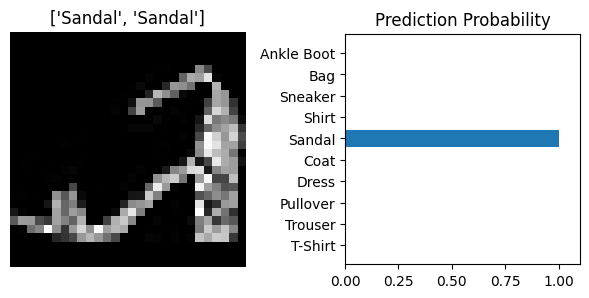

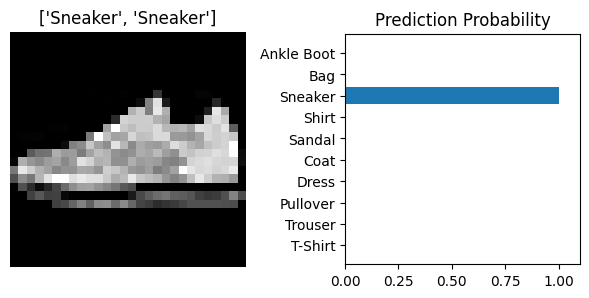

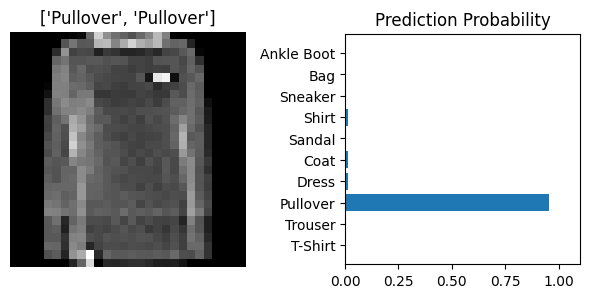

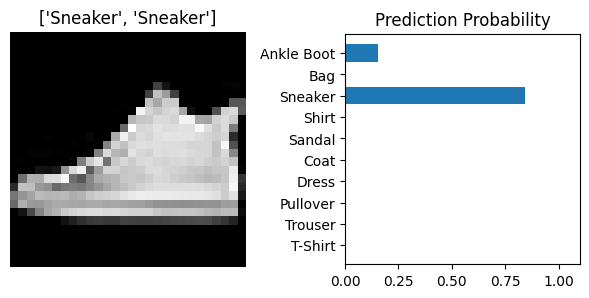

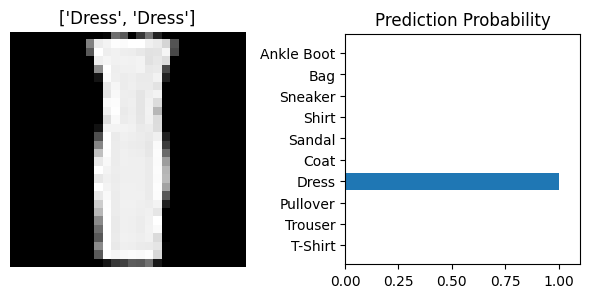

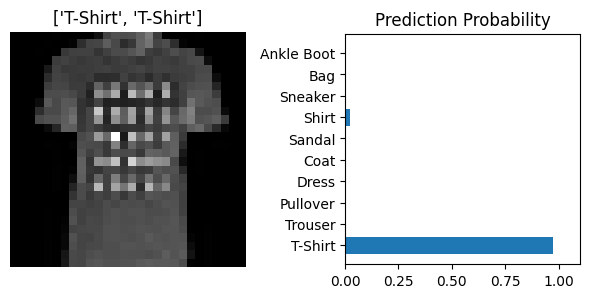

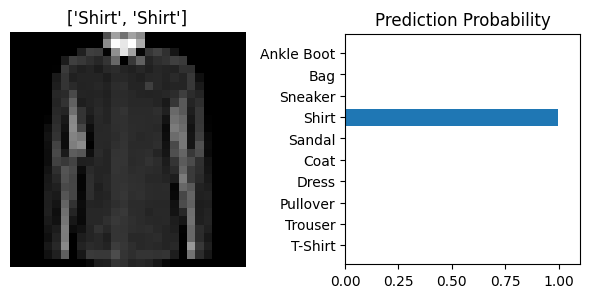

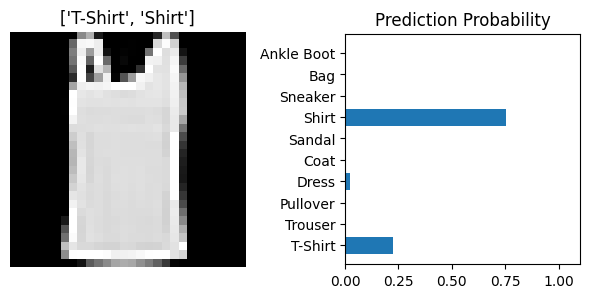

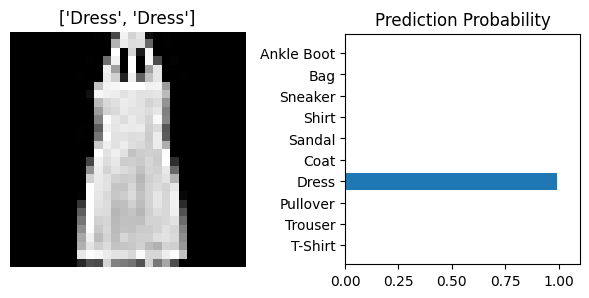

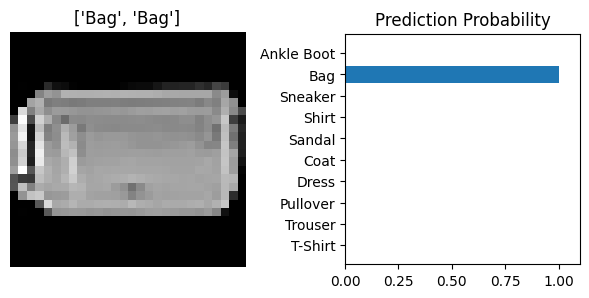

In [26]:
model_fnn.to("cpu")

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

# CNN


In [54]:
# function to count number of parameters
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


accuracy_list = []


# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.float()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.float()
        output = model(data)
        test_loss += F.nll_loss(
            output, target, reduction="sum"
        ).item()  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[
            1
        ]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), accuracy
        )
    )

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(
            in_channels=50, out_channels=50, kernel_size=6, padding=0
        )
        self.conv3 = nn.Conv2d(
            in_channels=50, out_channels=50, kernel_size=6, padding=0
        )
        self.FLATTEN_LEN = 50 * 2 * 2
        self.fc1 = nn.Linear(self.FLATTEN_LEN, 10)
        # self.fc2 = nn.Linear(200, 10)

    def forward(self, x, verbose=False):
        # print("input", x.shape)

        x = self.conv1(x)
        x = F.relu(x)
        # print("after conv1", x.shape)

        x = self.conv2(x)
        x = F.relu(x)
        # print("after conv2", x.shape)

        x = F.max_pool2d(x, kernel_size=2)
        # print("after 1st maxpool", x.shape)

        x = self.conv3(x)
        x = F.relu(x)
        # print("after conv3", x.shape)

        x = F.max_pool2d(x, kernel_size=2)
        # print("after 2nd maxpool", x.shape)

        x = x.view(-1, self.FLATTEN_LEN)
        # print("after tensor shape change", x.shape)

        x = self.fc1(x)
        # x = F.relu(x)
        # print("after fc1", x.shape)

        # x = self.fc2(x)
        ##print("after fc2", x.shape)

        x = F.log_softmax(x, dim=0)
        return x

In [ ]:
print("Training on ", device)
model_cnn = CNN(784, 10)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print("Number of parameters: {}".format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 182610
Train Epoch: 0 [0/60000 (0%)]	Loss: 4.161188
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.802408
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.946476
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.699777
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.573629
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.493214
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.587528
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.468199
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.445551
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.434969

Test set: Average loss: 5.1803, Accuracy: 8179/10000 (82%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.273003
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.395907
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.306123
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.279800
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.436144
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.389797
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.436992
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.308367
Tr

In [61]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), x.size(1))


class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.C = 64
        self.network = nn.Sequential(
            # Layer 0
            nn.Conv2d(1, self.C, kernel_size=1, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(self.C),
            nn.ReLU(),
            # Layer 1
            nn.Conv2d(
                self.C, self.C * 2, kernel_size=3, stride=1, padding=1, bias=True
            ),
            nn.BatchNorm2d(self.C * 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Layer 2
            nn.Conv2d(
                self.C * 2, self.C * 4, kernel_size=3, stride=1, padding=1, bias=True
            ),
            nn.BatchNorm2d(self.C * 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Layer 3
            nn.Conv2d(
                self.C * 4, self.C * 8, kernel_size=3, stride=1, padding=1, bias=True
            ),
            nn.BatchNorm2d(self.C * 8),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Layer 4
            nn.MaxPool2d(4, padding=1),
            Flatten(),
            nn.Linear(self.C * 8, output_size, bias=True),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        return self.network(x)

In [62]:
print("Training on ", device)
model_cnn = CNN(784, 10)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print("Number of parameters: {}".format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 1556362
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.562013
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.769576
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.550054
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.229879
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.403018
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.558309
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.458044
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.318255
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.389874
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.273800

Test set: Average loss: 0.3988, Accuracy: 8566/10000 (86%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.337737
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.346982
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.339890
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.233269
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.169767
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.385794
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.179898
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.148468
T

In [63]:
torch.save(model_cnn.state_dict(), "assignment-1/saved-model/cnn-fashion-mnist.pth")

# Performance of CNN on visual information

Checking if performance of the CNN varies if the images are scrambled


In [16]:
accuracy_list = []


def scramble_train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28 * 28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        data = data.float()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


def scramble_test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28 * 28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        data = data.float()
        output = model(data)
        test_loss += F.nll_loss(
            output, target, reduction="sum"
        ).item()  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[
            1
        ]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), accuracy
        )
    )

In [17]:
fixed_perm = torch.randperm(784)
print("Training on ", device)
model_cnn_scrambled = CNN(784, 10)
model_cnn_scrambled.to(device)
optimizer = optim.SGD(model_cnn_scrambled.parameters(), lr=0.1, momentum=0.5)
print("Number of parameters: {}".format(get_n_params(model_cnn_scrambled)))

for epoch in range(0, 10):
    scramble_train(epoch, model_cnn_scrambled, fixed_perm)
    scramble_test(model_cnn_scrambled, fixed_perm)

Training on  cuda:0
Number of parameters: 1556362
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.757199
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.000408
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.441453
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.412700
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.523823
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.469422
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.528520
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.329277
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.439796
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.414187

Test set: Average loss: 0.4136, Accuracy: 8538/10000 (85%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.529772
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.444923
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.426041
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.406036
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.318891
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.404948
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.391187
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.392834
T

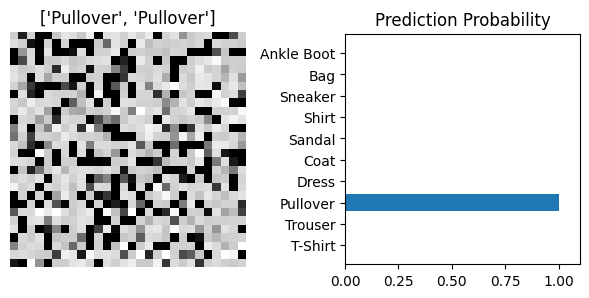

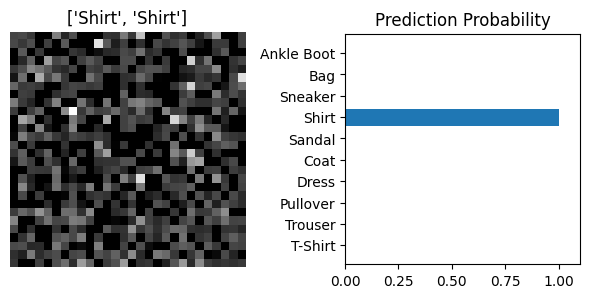

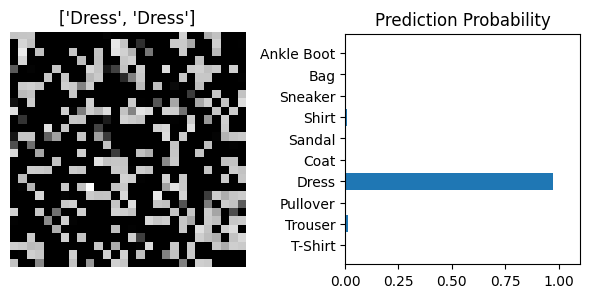

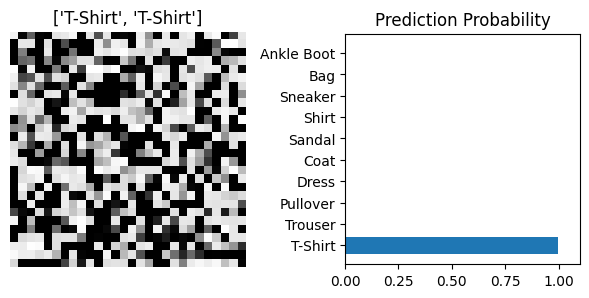

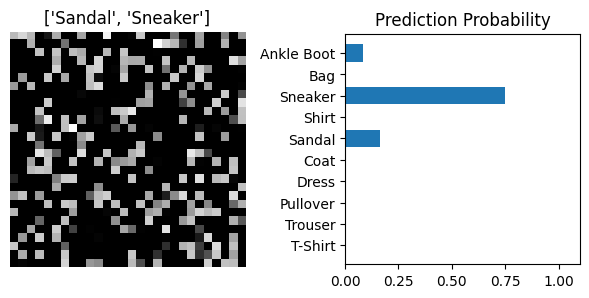

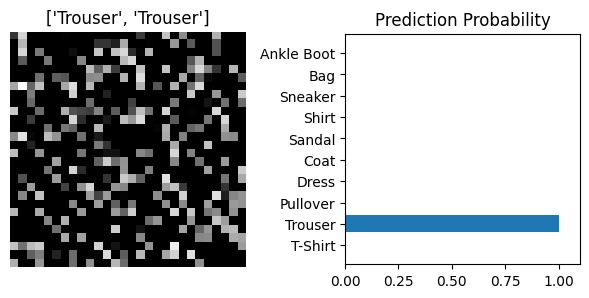

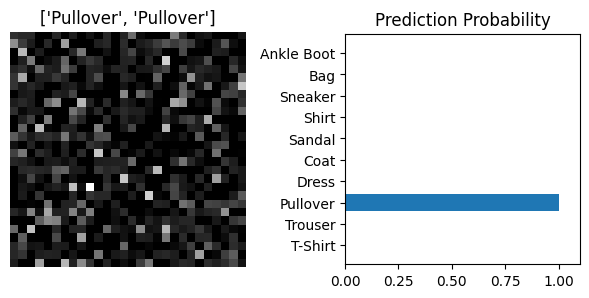

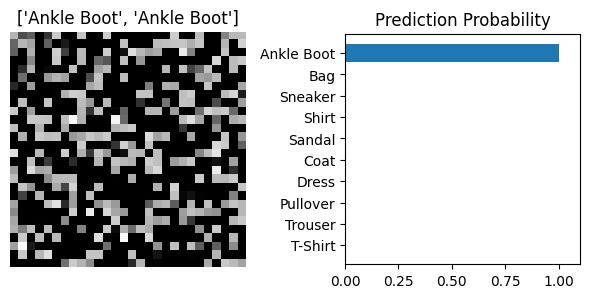

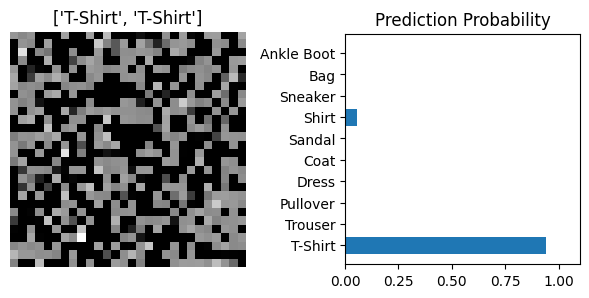

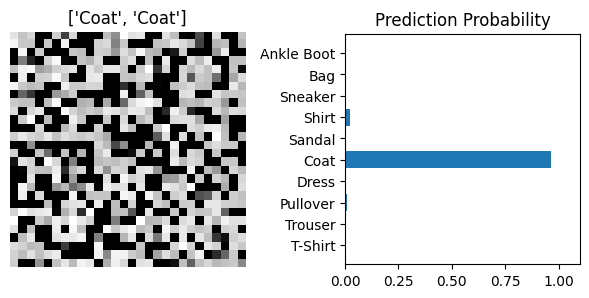

In [27]:
model_cnn_scrambled.to("cpu")

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 28 * 28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)
# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn_scrambled(image_batch_scramble.float())
for i in range(10):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img_perm, pred_prob, real_label)

We see that in this case, the performance remains constant at 87%, not much decrease from the normal case


# FGSM attack


In [28]:
epsilons = [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]


# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image using the gradients
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [-1,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

In [64]:
test_loader = DataLoader(
    CustomDataset(
        df_test, transform=test_transform
    ),  # Use ToTensor to convert the image to a PyTorch tensor
    batch_size=1,
    shuffle=True,  # You can adjust the batch size as needed
)

In [50]:
def fgsm_test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    model.to(device)
    model.eval()

    progress_count = 0
    # Loop over all examples in test set, one by one (test_loader has batch_size=1)
    for data, target in test_loader:
        progress_count += 1
        if progress_count % 1000 == 0:
            print("FGSM Attack Iteration: {}".format(progress_count * len(data)))

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        # Zero all existing gradients
        data = data.float()
        data.requires_grad = True
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[
            1
        ]  # get the index of the max log-probability

        # If the model is wrong, then this can't be an adversarial example, move on to the next example
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect gradients of the data
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        perturbed_data = perturbed_data.to(device)
        perturbed_data = perturbed_data.float()
        # Apply the model to the perturbed image
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[
            1
        ]  # get the index of the max log-probability

        # check if the perturbation forces a misclassification
        if final_pred.item() != target.item():
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                real_im = data.squeeze().detach().cpu().numpy()
                adv_examples.append(
                    (init_pred.item(), final_pred.item(), adv_ex, real_im)
                )
        else:
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    print(
        "Epsilon: {}\tTest Accuracy = {} / {} = {}".format(
            epsilon, correct, len(test_loader), final_acc
        )
    )

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [65]:
model_cnn = CNN(784, 10)
model_cnn.to(device)
model_cnn.load_state_dict(torch.load("assignment-1/saved-model/cnn-fashion-mnist.pth"))
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = fgsm_test(model_cnn, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

FGSM Attack Iteration: 1000
FGSM Attack Iteration: 2000
FGSM Attack Iteration: 3000
FGSM Attack Iteration: 4000
FGSM Attack Iteration: 5000
FGSM Attack Iteration: 6000
FGSM Attack Iteration: 7000
FGSM Attack Iteration: 8000
FGSM Attack Iteration: 9000
FGSM Attack Iteration: 10000
Epsilon: 0	Test Accuracy = 8838 / 10000 = 0.8838
FGSM Attack Iteration: 1000
FGSM Attack Iteration: 2000
FGSM Attack Iteration: 3000
FGSM Attack Iteration: 4000
FGSM Attack Iteration: 5000
FGSM Attack Iteration: 6000
FGSM Attack Iteration: 7000
FGSM Attack Iteration: 8000
FGSM Attack Iteration: 9000
FGSM Attack Iteration: 10000
Epsilon: 0.001	Test Accuracy = 8817 / 10000 = 0.8817
FGSM Attack Iteration: 1000
FGSM Attack Iteration: 2000
FGSM Attack Iteration: 3000
FGSM Attack Iteration: 4000
FGSM Attack Iteration: 5000
FGSM Attack Iteration: 6000
FGSM Attack Iteration: 7000
FGSM Attack Iteration: 8000
FGSM Attack Iteration: 9000
FGSM Attack Iteration: 10000
Epsilon: 0.002	Test Accuracy = 8799 / 10000 = 0.8799
FG

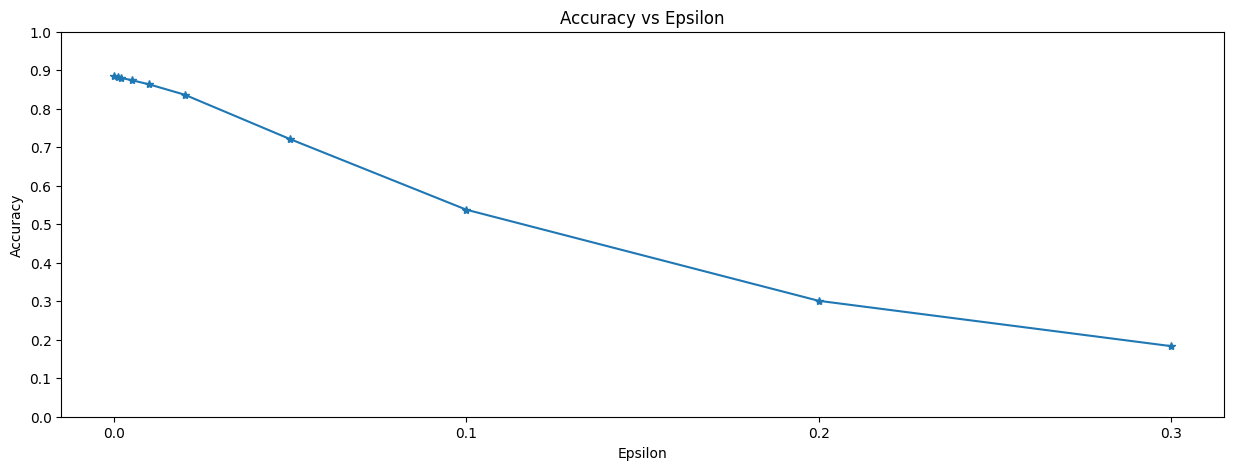

In [66]:
plt.figure(figsize=(15, 5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(numpy.arange(0, 1.1, step=0.1))
plt.xticks(numpy.arange(0, 0.4, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()